# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!unzip /content/drive/MyDrive/Project_data.zip

In [1]:
import numpy as np
import os
from cv2 import imread, resize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5)  # count for loading folders for 5 classes
    train_data = []
    val_data = []

    # when ablation is None, pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            label = int(doc.strip().split(';')[2])
            if counts[label] < ablation:
                train_data.append(doc)
                counts[label] += 1

        counts = np.zeros(5)

        # iterating val doc
        for doc in val_doc:
            label = int(doc.strip().split(';')[2])
            if counts[label] < ablation:
                val_data.append(doc)
                counts[label] += 1
    else:
        train_data, val_data = train_doc, val_doc

    return train_data, val_data


In [ ]:
# # train and validatiaon data creator with ablation
# # when ablation is 10, then 10 folders for each label will be selected.
# def get_data(path, ablation=None):
#     train_doc = np.random.permutation(open(path+'train.csv').readlines())
#     val_doc = np.random.permutation(open(path+'val.csv').readlines())
#     counts = np.zeros(5) # count for loading folders for 5 classes
#     train_data = []
#     val_data = []
#     # when ablation is None pass full training and val data
#     if ablation is not None:
#         # iterating train doc
#         for doc in train_doc:
#             lable = int(doc.strip().split(';')[2])
#             if counts[lable] < ablation:
#                 train_data.append(doc)
#                 counts[lable] += 1
#         counts = np.zeros(5)
#         # iterating val doc
#         for doc in val_doc:
#             lable = int(doc.strip().split(';')[2])
#             if counts[lable] < ablation:
#                 val_data.append(doc)
#                 counts[lable] += 1
#     else:
#         train_data, val_data = train_doc, val_doc
#     return train_data, val_data

In [22]:
train_doc, val_doc = get_data('Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# def generator(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     img_idx = seq_idx#create a list of image numbers you want to use for a particular video
#     x = len(img_idx)
#     y = dim_x
#     z = dim_y
#     while True:
#         t = np.random.permutation(folder_list)
#         num_batches = len(source_path)//batch_size # calculate the number of batches
#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)



#                     # Cropped image of above dimension
#                     # (It will not change orginal image)

#                     #image = image.crop((0, 0, 120, 120))
#                     image = resize(image, (dim_x, dim_y))


#                     #crop the images and resize them. Note that the images are of 2 different shape
#                     #and the conv3D will throw error if the inputs in a batch have different shapes

#                     batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
#                     batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
#                     batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


#         # write the code for the remaining data points which are left after full batches
#         if((len(source_path)%batch_size)//2==0):
#             batch_size = 2
#         else:
#             batch_size = 1
#         num_batches = len(source_path)%batch_size # calculate the number of batches
#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)



#                     # Cropped image of above dimension
#                     # (It will not change orginal image)

#                     #image = image.crop((0, 0, 120, 120))
#                     image = resize(image, (dim_x, dim_y))


#                     #crop the images and resize them. Note that the images are of 2 different shape
#                     #and the conv3D will throw error if the inputs in a batch have different shapes

#                     batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
#                     batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
#                     batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [5]:
# generator without augmentation and cropping for train data
def generator(source_path, folder_list, batch_size):
    img_idx = seq_idx  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)

        if (len(t) % batch_size) == 0:
            num_batches = int(len(t) / batch_size)
        else:
            num_batches = len(t) // batch_size + 1

        for batch in range(num_batches):  # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5))  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                # handling remaining datapoints
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path + '/' + folder_str.split(';')[0])  # read all the images in the folder

                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path + '/' + folder_str.strip().split(';')[0] + '/' + imgs[item]).astype(
                        np.float32)

                    # resize the images. Note that the images are of 2 different shapes
                    # and the conv3D will throw an error if the inputs in a batch have different shapes
                    resized_im = resize(image, dsize=(y, z))

                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # you yield the batch_data and the batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [23]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  'Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

# Final Model

In [ ]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [ ]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 445568)            0         
                                                                 
 dense (Dense)               (None, 128)               57032832  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 57,036,101
Trainable params: 57,036,101
Non-trainable params: 0
____________________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
from keras.callbacks import EarlyStopping

model_name = 'gesture_recognition_conv3d_batch_size_32' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR, earlystop]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 414.1875 - categorical_accuracy: 0.3672 
Epoch 1: saving model to gesture_recognition_conv3d_batch_size_32_2024-02-2916_34_01.394090/model-00001-414.18750-0.36719-4.09986-0.18750.h5
4/4 [==============================] - 113s 30s/step - loss: 414.1875 - categorical_accuracy: 0.3672 - val_loss: 4.0999 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 1.7368 - categorical_accuracy: 0.1953 
Epoch 2: saving model to gesture_recognition_conv3d_batch_size_32_2024-02-2916_34_01.394090/model-00002-1.73678-0.19531-1.57821-0.21875.h5
4/4 [==============================] - 105s 28s/step - loss: 1.7368 - categorical_accuracy: 0.1953 - val_loss: 1.5782 - val_categorical_accuracy: 0.2188 - lr: 0.0100
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 1.2589 - categorical_accuracy: 0.1562 
Epoch 3: saving model to gesture_recognition_conv3d_batch_size_32_202

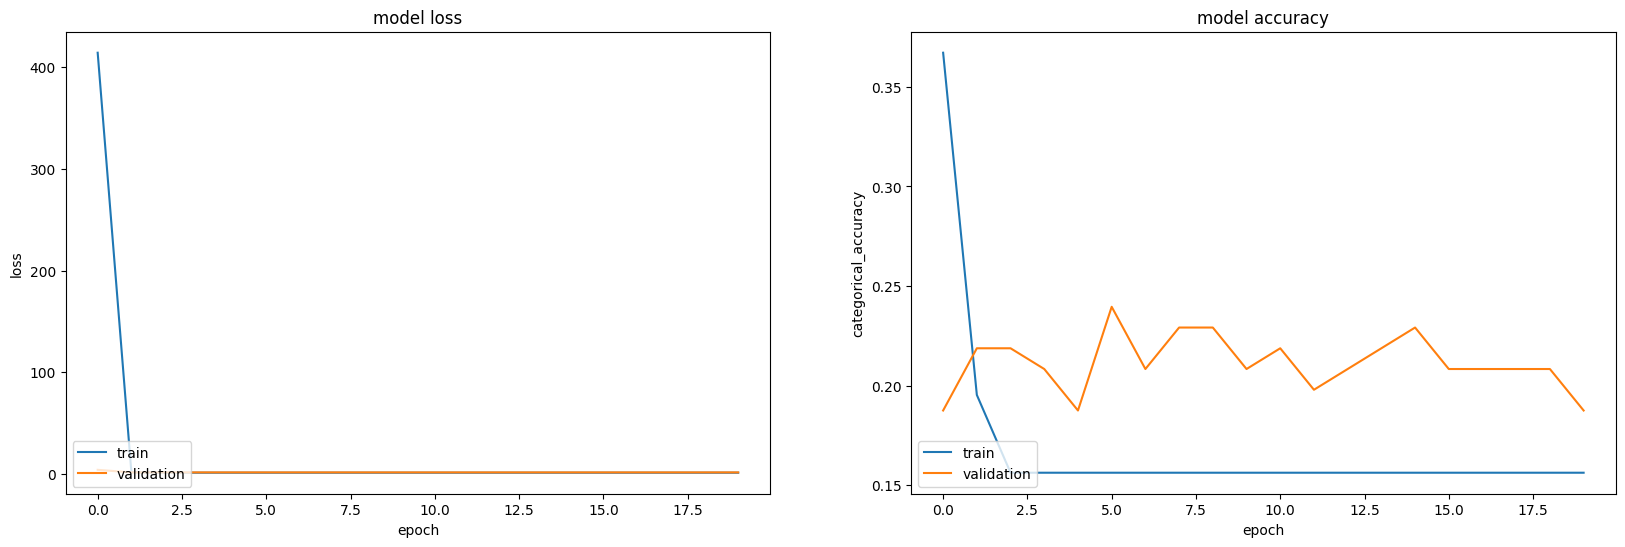

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [ ]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [ ]:
#optimiser = optimizers.Adam(lr=0.01) #write your optimizer
#model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 194.8313 - categorical_accuracy: 0.3906 
Epoch 1: saving model to gesture_recognition_conv3d_batch_size_32_2024-02-2916_34_01.394090/model-00001-194.83133-0.39062-3.39520-0.13542.h5
4/4 [==============================] - 118s 31s/step - loss: 194.8313 - categorical_accuracy: 0.3906 - val_loss: 3.3952 - val_categorical_accuracy: 0.1354 - lr: 0.0100
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 2.1457 - categorical_accuracy: 0.1641 
Epoch 2: saving model to gesture_recognition_conv3d_batch_size_32_2024-02-2916_34_01.394090/model-00002-2.14573-0.16406-1.57558-0.20833.h5
4/4 [==============================] - 111s 29s/step - loss: 2.1457 - categorical_accuracy: 0.1641 - val_loss: 1.5756 - val_categorical_accuracy: 0.2083 - lr: 0.0100
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 1.2378 - categorical_accuracy: 0.1953 
Epoch 3: saving model to gesture_recognition_conv3d_batch_size_32_202

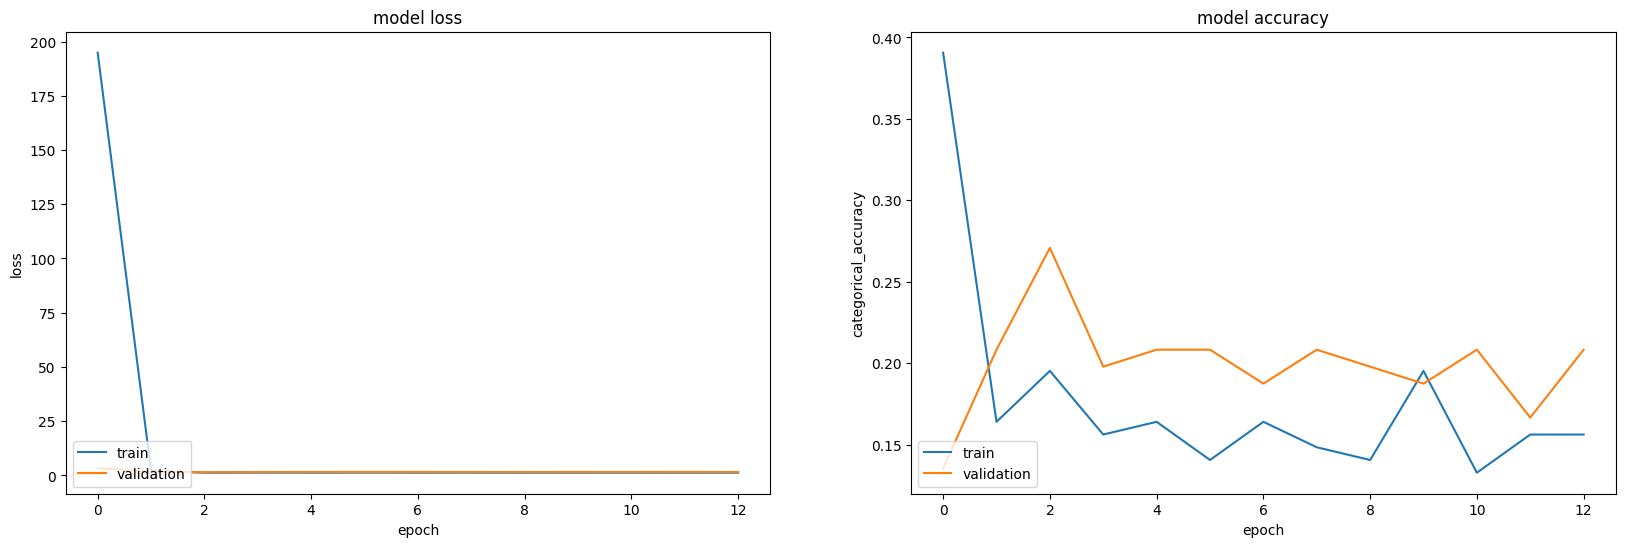

In [ ]:
# plt.figure(figsize=(20,6))
# ax1 = plt.subplot(121)
# ax1 = plt.plot(history.history['loss'])
# ax1 = plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='lower left')
# ax2 = plt.subplot(122)
# ax2 = plt.plot(history.history['categorical_accuracy'])
# ax2 = plt.plot(history.history['val_categorical_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('categorical_accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='lower left')

In [10]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [11]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_7 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 3, 58, 58, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 1, 28, 28, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_9 (Conv3D)           (None, 1, 26, 26, 256)   

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 1.7996 - categorical_accuracy: 0.1406 
Epoch 1: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00001-1.79964-0.14062-1.59955-0.16667.h5
4/4 [==============================] - 162s 41s/step - loss: 1.7996 - categorical_accuracy: 0.1406 - val_loss: 1.5995 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 1.2654 - categorical_accuracy: 0.1797 
Epoch 2: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00002-1.26543-0.17969-1.58117-0.17708.h5
4/4 [==============================] - 150s 38s/step - loss: 1.2654 - categorical_accuracy: 0.1797 - val_loss: 1.5812 - val_categorical_accuracy: 0.1771 - lr: 0.0010
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 1.2623 - categorical_accuracy: 0.3750 
Epoch 3: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0

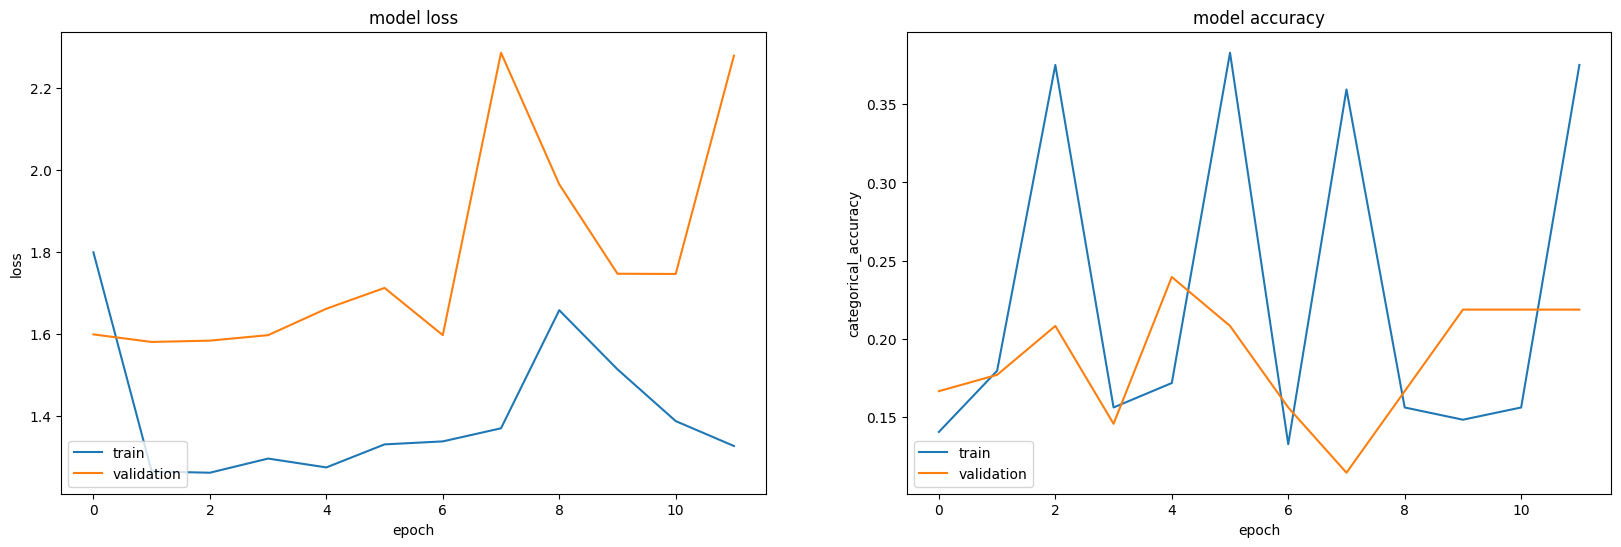

In [17]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [18]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [19]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_13 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 3, 58, 58, 64)     0         
 g3D)                                                            
                                                                 
 batch_normalization (Batch  (None, 3, 58, 58, 64)     256       
 Normalization)                                                  
                                                                 
 conv3d_14 (Conv3D)          (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 1, 28, 28, 128)   

In [20]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 2.9077 - categorical_accuracy: 0.3125 
Epoch 1: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00001-2.90771-0.31250-2.62590-0.21875.h5
4/4 [==============================] - 153s 38s/step - loss: 2.9077 - categorical_accuracy: 0.3125 - val_loss: 2.6259 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 1.5363 - categorical_accuracy: 0.4844 
Epoch 2: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00002-1.53629-0.48438-8.29389-0.27083.h5
4/4 [==============================] - 152s 39s/step - loss: 1.5363 - categorical_accuracy: 0.4844 - val_loss: 8.2939 - val_categorical_accuracy: 0.2708 - lr: 0.0010
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.8078 - categorical_accuracy: 0.5938 
Epoch 3: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0

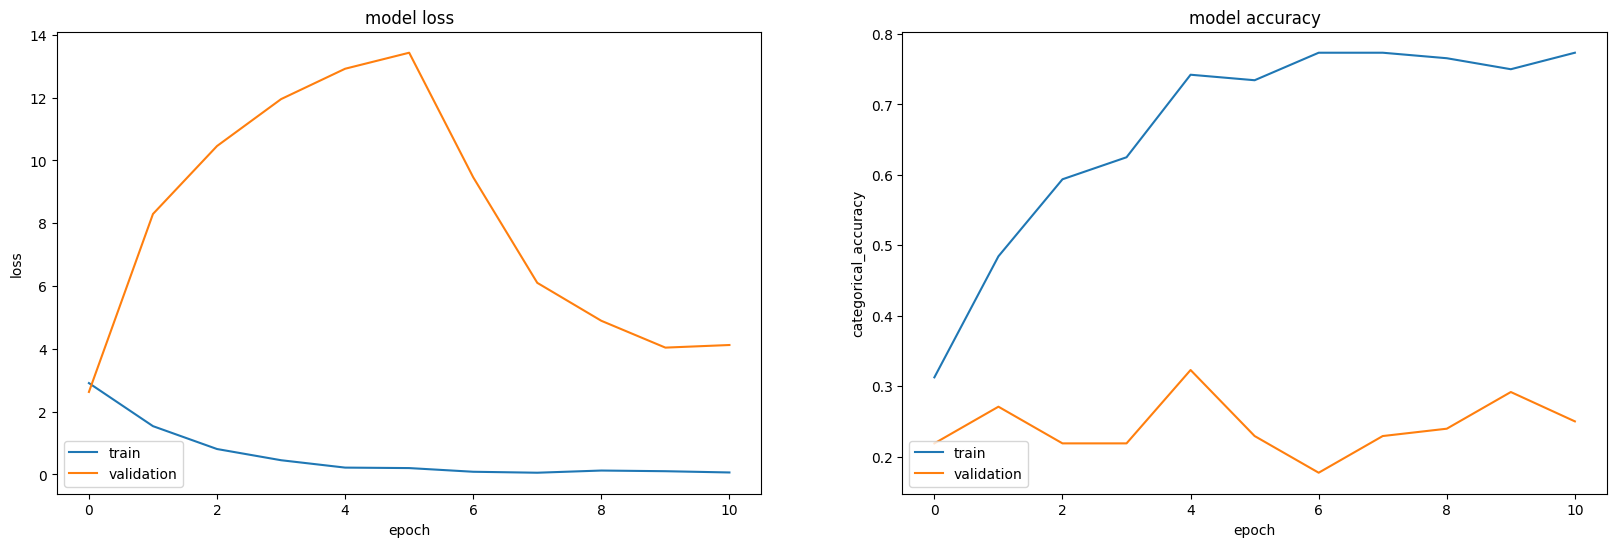

In [21]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [25]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 2.0250 - categorical_accuracy: 0.5156 
Epoch 1: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00001-2.02501-0.51562-4.51388-0.30208.h5
4/4 [==============================] - 152s 39s/step - loss: 2.0250 - categorical_accuracy: 0.5156 - val_loss: 4.5139 - val_categorical_accuracy: 0.3021 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 1.3841 - categorical_accuracy: 0.5234 
Epoch 2: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00002-1.38407-0.52344-9.74005-0.21875.h5
4/4 [==============================] - 151s 38s/step - loss: 1.3841 - categorical_accuracy: 0.5234 - val_loss: 9.7401 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 1.2179 - categorical_accuracy: 0.5391 
Epoch 3: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0

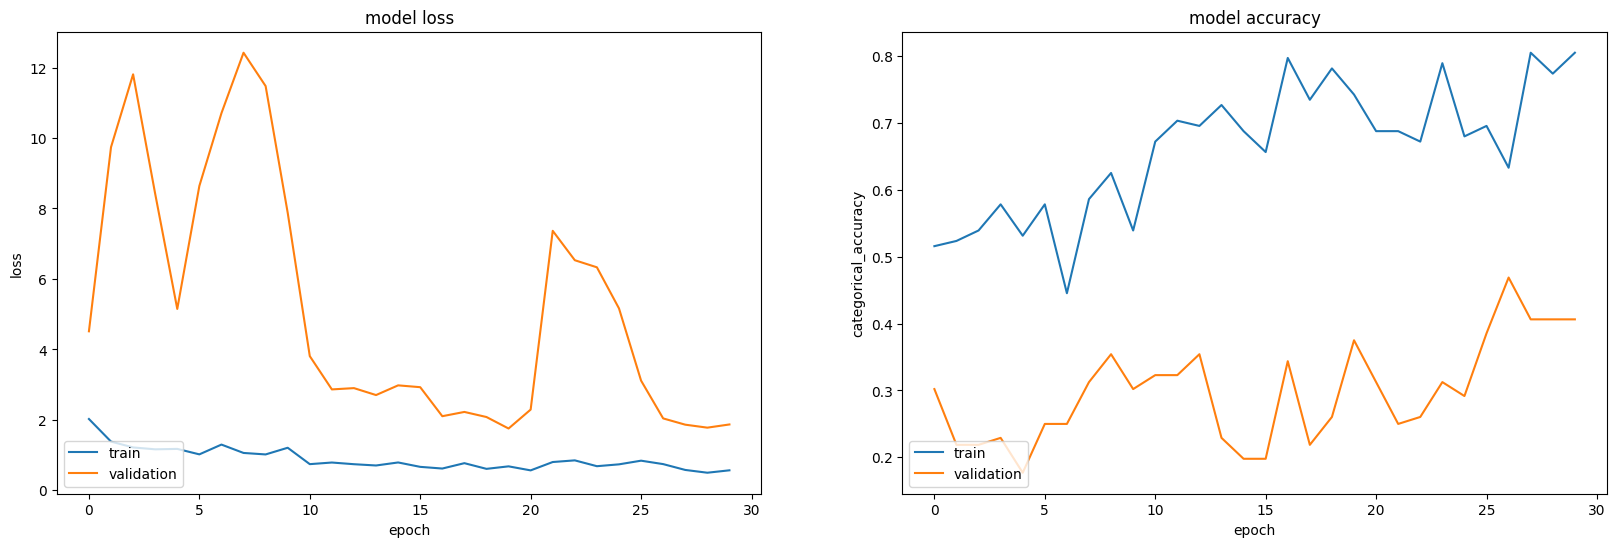

In [26]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [27]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [28]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_19 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 3, 58, 58, 64)     0         
 ng3D)                                                           
                                                                 
 batch_normalization_5 (Bat  (None, 3, 58, 58, 64)     256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_20 (Conv3D)          (None, 1, 56, 56, 128)   

In [29]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 2.3041 - categorical_accuracy: 0.3438 
Epoch 1: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00001-2.30411-0.34375-1.78690-0.23958.h5
4/4 [==============================] - 154s 38s/step - loss: 2.3041 - categorical_accuracy: 0.3438 - val_loss: 1.7869 - val_categorical_accuracy: 0.2396 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 2.8551 - categorical_accuracy: 0.3203 
Epoch 2: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00002-2.85515-0.32031-2.61060-0.25000.h5
4/4 [==============================] - 151s 39s/step - loss: 2.8551 - categorical_accuracy: 0.3203 - val_loss: 2.6106 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 2.3083 - categorical_accuracy: 0.4219 
Epoch 3: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0

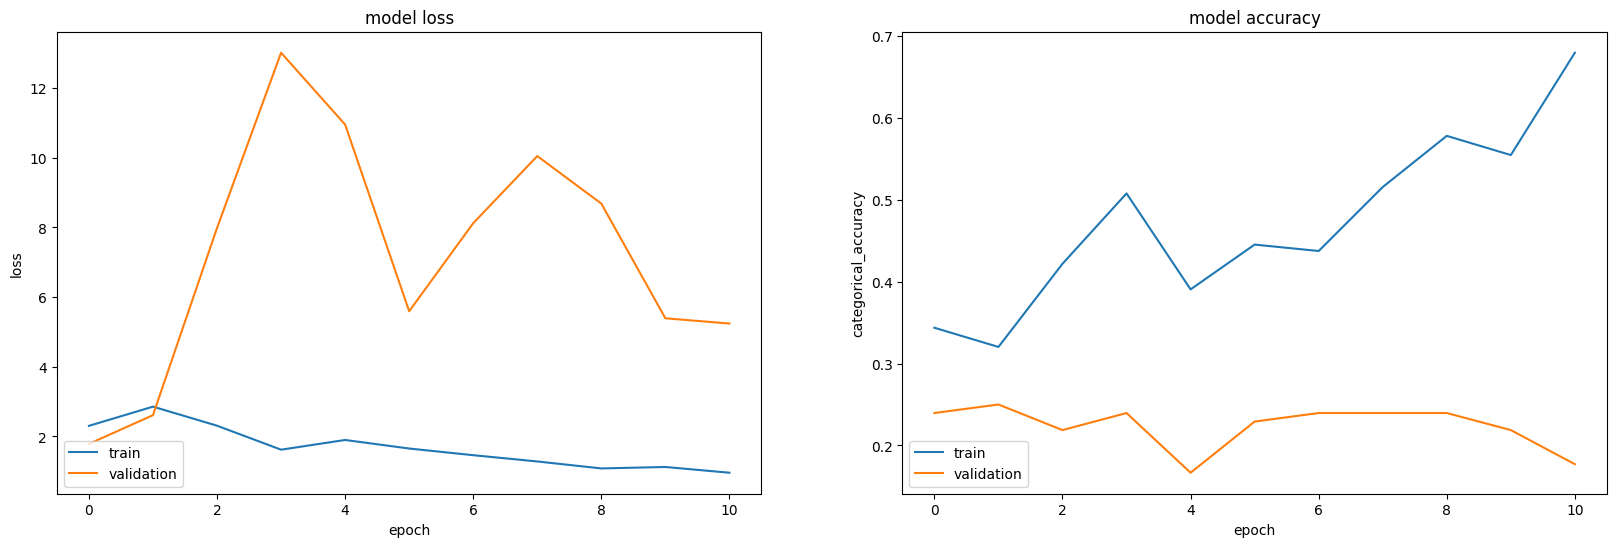

In [30]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')


In [34]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [35]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_29 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_19 (MaxPooli  (None, 3, 58, 58, 64)     0         
 ng3D)                                                           
                                                                 
 batch_normalization_14 (Ba  (None, 3, 58, 58, 64)     256       
 tchNormalization)                                               
                                                                 
 dropout_7 (Dropout)         (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_30 (Conv3D)          (None, 1, 56, 56, 128)   

In [36]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 1.9968 - categorical_accuracy: 0.3125 
Epoch 1: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00001-1.99679-0.31250-1.58960-0.23958.h5
4/4 [==============================] - 149s 37s/step - loss: 1.9968 - categorical_accuracy: 0.3125 - val_loss: 1.5896 - val_categorical_accuracy: 0.2396 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 1.4042 - categorical_accuracy: 0.4688 
Epoch 2: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0114_36_07.092372\model-00002-1.40421-0.46875-1.68253-0.22917.h5
4/4 [==============================] - 149s 38s/step - loss: 1.4042 - categorical_accuracy: 0.4688 - val_loss: 1.6825 - val_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 1.1733 - categorical_accuracy: 0.5781 
Epoch 3: saving model to gesture_recognition_conv3d_batch_size_32_2024-03-0

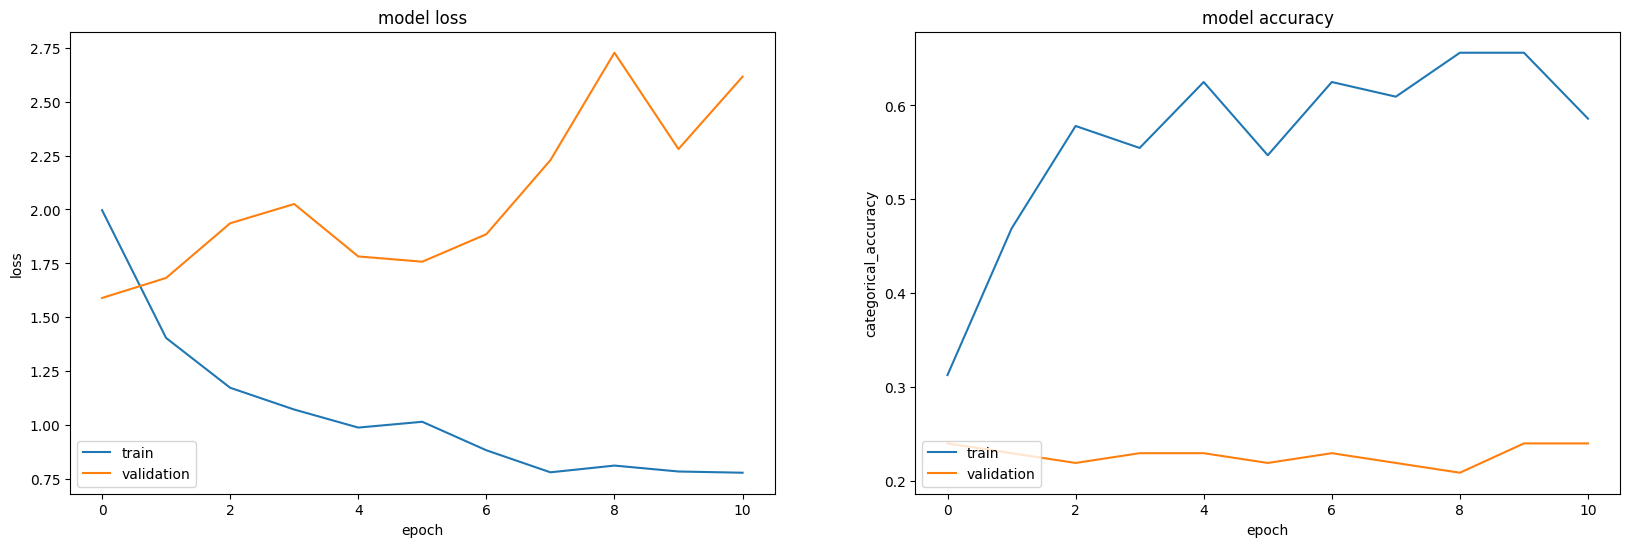

In [37]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
